In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from mpl_toolkits.mplot3d import Axes3D  
from pathlib import Path
import re
import time
%matplotlib inline

In [17]:
#INICIALIZACIÓN DE VARIABLES Y PATHS
# === PATHS ===
path_gen="/home/jorgebdelafuente/Doctorado/Quantics/PH2p_1TApp/ph2p/"
psi_0 = Path(path_gen+'psi_0.xyz')
psi_15 = Path(path_gen+'psi_15.xyz')
psi_30 = Path(path_gen+'psi_30.xyz')
psi_45 = Path(path_gen+'psi_45.xyz')
psi_60 = Path(path_gen+'psi_60.xyz')
psi_75 = Path(path_gen+'psi_75.xyz')
psi_90 = Path(path_gen+'psi_90.xyz')
# === VARIABLES ===
T_INDEX = 0 # Indice de tiempo
RG_TOL = 1.e-8 # Tolerancia RG para nuevo tiempo
DEFAULT_THETA_RAD = None # Valor por defecto de theta_rad
FPS = 4

SAVE_GIF_3D = False
GIF3D_PATH = "wp_jacobi_3D.gif"
writer = FFMpegWriter(fps=FPS, codec="libx264", bitrate=-1)

In [18]:
def get_ic(rg,rp,theta):
    # thrad=np.radians(theta)
    r12=((rp*0.50)*(rp*0.50)+rg*rg-2.0*0.50*rp*rg*np.cos(theta))**0.50
    r13=((rp*0.50)*(rp*0.50)+rg*rg-2.0*0.50*rp*rg*np.cos(np.pi-theta))**0.50
    r23=rp
    return r12,r13,r23

def get_ic_v2(rg, rp, theta):
    # rg: distancia P->COM(D2)
    # rp: distancia D-D (longitud del dímero)
    # theta: ángulo entre el eje del dímero y R (Jacobi)
    half = 0.5 * rp
    cosT = np.cos(theta)
    common = rg*rg + half*half
    r12 = np.sqrt(common + rg*rp*cosT)   # P–D1
    r13 = np.sqrt(common - rg*rp*cosT)   # P–D2
    r23 = rp                             # D–D
    return r12, r13, r23

In [19]:
def parse_angle_from_name(path: Path):
    m = re.search(r'(\d+)', path.stem)
    if not m:
        return None
    return np.deg2rad(float(m.group(1)))

def load_blocks(path: Path,rg_tol=1e-8):
    rows = []
    for line in path.read_text().splitlines():
        s = line.strip()
        if not s or s.startswith("#"): 
            continue
        parts = s.split()
        if len(parts) < 3: 
            continue
        rp, rg, val = map(float, parts[:3])
        rows.append((rp, rg, val))
    if not rows:
        raise ValueError("No se han leído datos numéricos.")
    
    blocks = []
    current = []
    prev_rg = None
    for rp, rg, val in rows:
        if prev_rg is not None and (rg < prev_rg - rg_tol):
            # reinicio de rg -> nuevo tiempo
            if current:
                blocks.append(np.array(current))
                current = []
        current.append((rp, rg, val))
        prev_rg = rg
    if current:
        blocks.append(np.array(current))

    # Info del primer bloque (asumimos grid constante)
    rp0 = np.unique(blocks[0][:,0])
    rg0 = np.unique(blocks[0][:,1])
    return blocks, rp0, rg0

def block_to_grid(block, rp_u, rg_u):
    order = np.lexsort((block[:,0], block[:,1]))  # ordena por rg, luego rp
    b = block[order]
    val = b[:,2].reshape(len(rg_u), len(rp_u))
    return val


In [33]:
theta_rad = parse_angle_from_name(psi_75) if DEFAULT_THETA_RAD is None else DEFAULT_THETA_RAD
if theta_rad is None:
    raise ValueError("Ángulo no encontrado.")

blocks, rp0, rg0 = load_blocks(psi_75, RG_TOL)
t_total = len(blocks)
if t_total == 0:
    raise ValueError("No se han leído bloques de datos.")

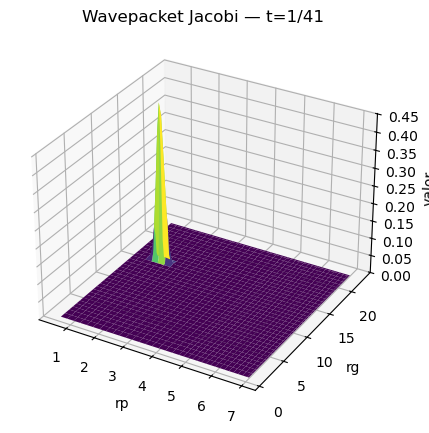

In [34]:
# --- mallas ---
RP, RG = np.meshgrid(rp0, rg0, indexing="xy")

def frame_val(i):
    return block_to_grid(blocks[i], rp0, rg0)

# --- figura ---
fig = plt.figure(figsize=(7,5))
ax  = fig.add_subplot(111, projection='3d')
ax.set_xlabel("rp"); ax.set_ylabel("rg"); ax.set_zlabel("valor")

Z0 = frame_val(0)
zmin, zmax = np.nanmin(Z0), np.nanmax(Z0)
ax.set_zlim(zmin, zmax)

title = ax.set_title(f"Wavepacket Jacobi — t=1/{len(blocks)}")

# IMPORTANTE: guardamos el surface como lista para mutarlo en update()
surf = [ax.plot_surface(RP, RG, Z0, cmap="viridis", linewidth=0, antialiased=True)]

# opcional: si el colorbar te da problemas al animar, quítalo
# fig.colorbar(surf[0], shrink=0.7, aspect=14, pad=0.08)

def init():
    """Primer frame (requerido por algunos backends/escritores)."""
    Zi = frame_val(0)
    surf[0].remove()
    surf[0] = ax.plot_surface(RP, RG, Zi, cmap="viridis", linewidth=0, antialiased=True)
    title.set_text(f"Wavepacket Jacobi — t=1/{len(blocks)}")
    return (surf[0],)

def update(i):
    Zi = frame_val(i)
    # reemplaza la superficie anterior
    surf[0].remove()
    surf[0] = ax.plot_surface(RP, RG, Zi, cmap="viridis", linewidth=0, antialiased=True)
    title.set_text(f"Wavepacket Jacobi — t={i+1}/{len(blocks)}")
    return (surf[0],)

anim = FuncAnimation(fig, update, frames=len(blocks), init_func=init,
                     interval=100, blit=False, repeat=False)

# Si to_jshtml no te aparece, guarda a GIF para verificar que anima:
# anim.save(path_gen+"wavepacket_jacobi.gif", writer=PillowWriter(fps=FPS))
anim.save(path_gen+"wavepacket_jacobi"+str(int(np.rad2deg(theta_rad)))+".mp4", writer=writer)
# plt.show()

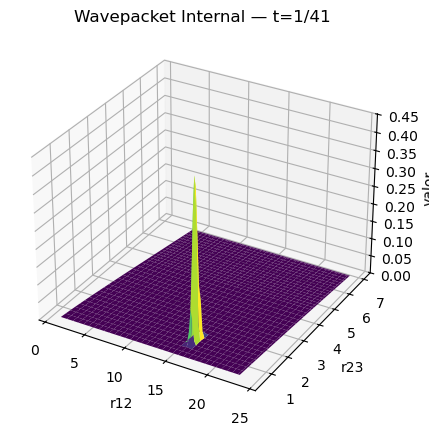

In [35]:
# --- mallas ---
RP, RG = np.meshgrid(rp0, rg0, indexing="xy")
R12,R13, R23 = get_ic_v2(RG, RP, theta_rad)

def frame_val(i):
    return block_to_grid(blocks[i], rp0, rg0)

# --- figura ---
fig2 = plt.figure(figsize=(7,5))
ax2  = fig2.add_subplot(111, projection='3d')
ax2.set_xlabel("r12"); ax2.set_ylabel("r23"); ax2.set_zlabel("valor")

Z0 = frame_val(0)
zmin, zmax = np.nanmin(Z0), np.nanmax(Z0)
ax2.set_zlim(zmin, zmax)

title = ax2.set_title(f"Wavepacket Internal — t=1/{len(blocks)}")

# IMPORTANTE: guardamos el surface como lista para mutarlo en update()
surf = [ax2.plot_surface(R12, R23, Z0, cmap="viridis", linewidth=0, antialiased=True)]

# opcional: si el colorbar te da problemas al animar, quítalo
# fig2.colorbar(surf[0], shrink=0.7, aspect=14, pad=0.08)

def init():
    """Primer frame (requerido por algunos backends/escritores)."""
    Zi = frame_val(0)
    surf[0].remove()
    surf[0] = ax2.plot_surface(R12, R23, Zi, cmap="viridis", linewidth=0, antialiased=True)
    title.set_text(f"Wavepacket Internal — t=1/{len(blocks)}")
    return (surf[0],)

def update(i):
    Zi = frame_val(i)
    # reemplaza la superficie anterior
    surf[0].remove()
    surf[0] = ax2.plot_surface(R12, R23, Zi, cmap="viridis", linewidth=0, antialiased=True)
    title.set_text(f"Wavepacket Internal — t={i+1}/{len(blocks)}")
    return (surf[0],)

anim = FuncAnimation(fig2, update, frames=len(blocks), init_func=init,
                     interval=100, blit=False, repeat=False)

# Si to_jshtml no te aparece, guarda a GIF para verificar que anima:
# anim.save(path_gen+"wavepacket_jacobi.gif", writer=PillowWriter(fps=FPS))
anim.save(path_gen+"wavepacket_internal"+str(int(np.rad2deg(theta_rad)))+".mp4", writer=writer)
# plt.show()